In [1]:
import numpy as np
import pandas as pd
import glob
import os
import scipy.stats
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from scipy.spatial import distance
import warnings
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [2]:
Directory_Path = 'C:/Users/99kit/Desktop/CapstoneDesign2/'
list_root_directory = ['Normal', 'CoreExposed', 'CoreSevered', 'SideDamaged']

def calculate_statistics(data):
    # mean = np.mean(data)
    var = np.var(data)
    max = np.max(data)
    # skew = scipy.stats.skew(data)
    kurt = scipy.stats.kurtosis(data)
    return var, kurt, max # mean, var, kurt, max #skew, kurt

data_frames = {}

for directory in list_root_directory:
    os.chdir(os.path.join(Directory_Path, directory))

    Tension = pd.read_csv(f"Tension_{directory}.csv", encoding='cp949')
    Tension['Unnamed: 0'] = pd.to_datetime(Tension['Unnamed: 0'], format='[%Y/%m/%d] %H:%M:%S')
    Tension['Formatted_Time'] = Tension['Unnamed: 0'].dt.strftime(f'NTRNL_{directory}\\%m-%d %H_%M_%S.txt')

    list_max_values = []
    for csv_file in glob.glob('*/*.csv'):
        df = pd.read_csv(csv_file)
        list_max_values.append(df['External Sound'].max())
    Tension['Max_EXT_Sound'] = list_max_values

    statistics = {}
    for txt_file in glob.glob('*/*.txt'):
        with open(txt_file, 'r') as file:
            data = [int(line.strip().split(',')[0]) for line in file if len(line.strip().split(',')) == 3]
            statistics[txt_file] = calculate_statistics(data)

    for stat_name in ['Variance', 'Kurtosis', 'Max']:#['Mean', 'Variance', 'Kurtosis', 'Max']: # 'Skewness', 'Kurtosis']:
        Tension[stat_name] = Tension['Formatted_Time'].map(lambda x: statistics.get(x, (np.nan, np.nan, np.nan, np.nan))[['Variance', 'Kurtosis', 'Max'].index(stat_name)]) # 'Mean', 'Variance', 'Kurtosis', 'Max'].index(stat_name)]) #  'Skewness', 'Kurtosis'].index(stat_name)])
        Tension[stat_name].interpolate(inplace=True)

    Q1 = Tension['Max_EXT_Sound'].quantile(0.25)
    Q3 = Tension['Max_EXT_Sound'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers_max_ext_sound = Tension[(Tension['Max_EXT_Sound'] < lower_bound) | (Tension['Max_EXT_Sound'] > upper_bound)]

    # Q1_mean = Tension['Mean'].quantile(0.25)
    # Q3_mean = Tension['Mean'].quantile(0.75)
    # IQR_mean = Q3_mean - Q1_mean
    # lower_bound_mean = Q1_mean - 1.5 * IQR_mean
    # upper_bound_mean = Q3_mean + 1.5 * IQR_mean
    # outliers_mean_ntrnl_sound = Tension[(Tension['Mean'] < lower_bound_mean) | (Tension['Mean'] > upper_bound_mean)]

    # common_indices = outliers_max_ext_sound.index.intersection(outliers_mean_ntrnl_sound.index)
    # Tension.loc[common_indices, 'Mean'] = np.nan
    # Tension['Mean'].interpolate(inplace=True)

    Q1_max = Tension['Max'].quantile(0.25)
    Q3_max = Tension['Max'].quantile(0.75)
    IQR_max = Q3_max - Q1_max
    lower_bound_max = Q1_max - 1.5 * IQR_max
    upper_bound_max = Q3_max + 1.5 * IQR_max
    outliers_max_ntrnl_sound = Tension[(Tension['Max'] < lower_bound_max) | (Tension['Max'] > upper_bound_max)]
    
    common_indices = outliers_max_ext_sound.index.intersection(outliers_max_ntrnl_sound.index)
    Tension.loc[common_indices, 'Max'] = np.nan
    Tension['Max'].interpolate(inplace=True)

    Tension = Tension.drop(['Formatted_Time', 'Max_EXT_Sound'], axis=1)
    Tension['Type'] = directory

    Tension.loc[Tension['Type'] != 'Normal', 'Confusion Matrix'] = 'Others'
    Tension.loc[Tension['Type'] == 'Normal', 'Confusion Matrix'] = 'Normal'

    data_frames[directory] = Tension

# tb_data = pd.concat(data_frames.values(), ignore_index=True)
# tb_data = tb_data.rename(columns={'벨트처짐': 'Tension'})

# list_independent_variables = ['Tension', 'Mean', 'Variance', 'Skewness', 'Kurtosis']

# data_standardized = StandardScaler().fit_transform(tb_data[list_independent_variables])
# tb_data[list_independent_variables] = pd.DataFrame(data_standardized, columns=list_independent_variables)

# tb_data

In [3]:
# 위의 코드 전체 재실행이 너무 오래 걸려서 따로 똑 떼어냄

tb_data = pd.concat(data_frames.values(), ignore_index=True)
tb_data = tb_data.rename(columns={'벨트처짐': 'Tension'})

list_independent_variables = ['Tension', 'Variance', 'Kurtosis', 'Max'] # , 'Mean''Skewness', 'Kurtosis']

data_standardized = StandardScaler().fit_transform(tb_data[list_independent_variables])
tb_data[list_independent_variables] = pd.DataFrame(data_standardized, columns=list_independent_variables)

tb_data

,Unnamed: 0,Tension,Variance,Kurtosis,Max,Type,Confusion Matrix
0,2023-05-31 23:35:19,-0.216452,0.235485,0.005047,-1.151817,Normal,Normal
1,2023-05-31 23:35:20,-0.204667,0.059753,-0.858885,0.137134,Normal,Normal
2,2023-05-31 23:35:21,-0.216452,0.163329,-0.392346,-1.237747,Normal,Normal
3,2023-05-31 23:35:22,-0.240023,0.503912,-0.731790,-0.464376,Normal,Normal
4,2023-05-31 23:35:23,-0.240023,1.351871,-1.517878,-1.151817,Normal,Normal
...,...,...,...,...,...,...,...
14250,2023-05-31 21:53:55,-0.298951,-1.108551,1.508766,-0.421411,SideDamaged,Others
14251,2023-05-31 21:53:56,-0.240023,-0.717530,0.607366,-0.464376,SideDamaged,Others
14252,2023-05-31 21:53:57,0.007473,0.135900,-0.148179,-0.464376,SideDamaged,Others
14253,2023-05-31 21:53:58,-0.263594,-1.534583,1.726651,-0.464376,SideDamaged,Others


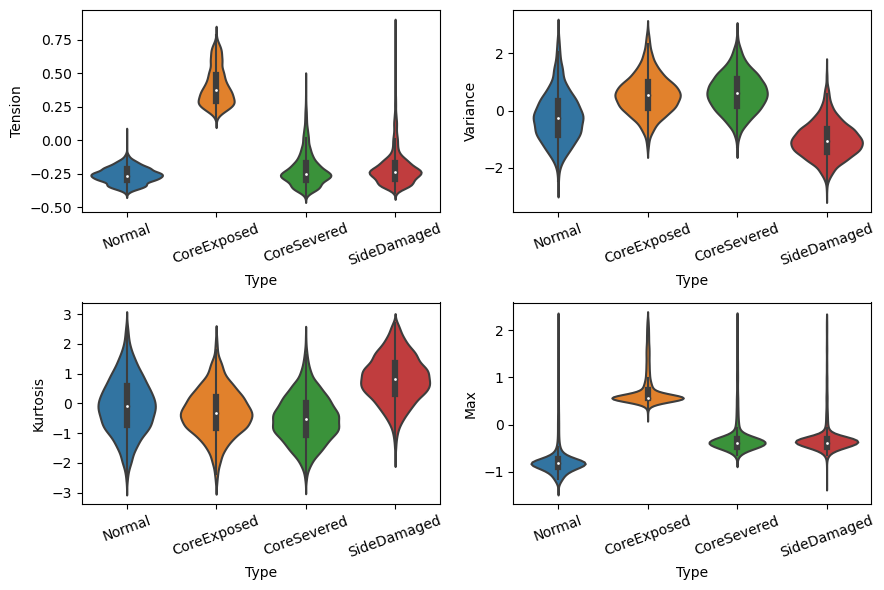

In [4]:
# 극단 이상치 제거한 바이올린 플롯 그리기
plt.figure(figsize=(9, 6))  # 그림 크기 설정

# 각 열에 대해 이상치 제거한 박스 플롯 그리기
for i, col in enumerate(list_independent_variables, 1):
    plt.subplot(2, 2, i)  # 2x3 그리드에서 i번째 위치에 서브플롯 생성

    # 이상치 제거 (IQR 기반)
    Q1 = tb_data[col].quantile(0.25)
    Q3 = tb_data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data_no_outliers = tb_data[(tb_data[col] >= lower_bound) & (tb_data[col] <= upper_bound)]

    sns.violinplot(x= 'Type', y = col, data=data_no_outliers)
    # plt.title(f'{col} (Outliers Removed) by Type')  # 서브플롯 제목 설정
    plt.xlabel('Type')  # x축 레이블 설정
    plt.ylabel(col)  # y축 레이블 설정
    plt.xticks(rotation=20)  # x축 레이블 회전

plt.tight_layout()  # 레이아웃 조정
plt.show()

In [5]:
X = tb_data[list_independent_variables]  # 독립 변수
y = tb_data['Type']  # 타겟 변수

# 상호 정보량 계산
mutual_info = mutual_info_classif(X, y, discrete_features='auto', random_state=42)

# 결과 출력
importance_scores = pd.Series(mutual_info, index=X.columns)
importance_scores = importance_scores.sort_values(ascending=False)
print('변수 중요도')
print(importance_scores)

변수 중요도
Max         0.799424
Tension     0.568701
Variance    0.326099
Kurtosis    0.169220
dtype: float64


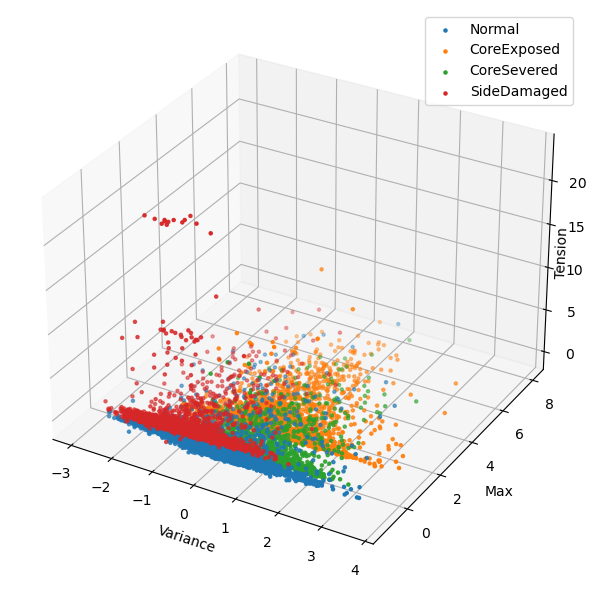

In [6]:
fig = plt.figure(figsize=(6, 6))
# ax = fig.add_subplot(111, projection='3d')
ax = plt.subplot(111, projection='3d')

tension = tb_data['Tension']
variance = tb_data['Variance']
# mean = tb_data['Mean']
max = tb_data['Max']
kurtosis = tb_data['Kurtosis']
type = tb_data['Type']

for t in tb_data['Type'].unique().tolist():
    mask = type == t
    ax.scatter(variance[mask], max[mask], tension[mask], label = t, marker = '.')

ax.set_xlabel('Variance')#, rotation=45)
ax.set_ylabel('Max')#, rotation=45)
ax.set_zlabel('Tension')#, rotation=45)

ax.zaxis.labelpad = -15

# azimuth_angle = 90
# elevation_angle = 90
# ax.view_init(elev=elevation_angle, azim=azimuth_angle)

ax.legend()
# plt.title('Scatter Plot of Tension, Variance, and Mean by Type')
plt.tight_layout()
# plt.show()

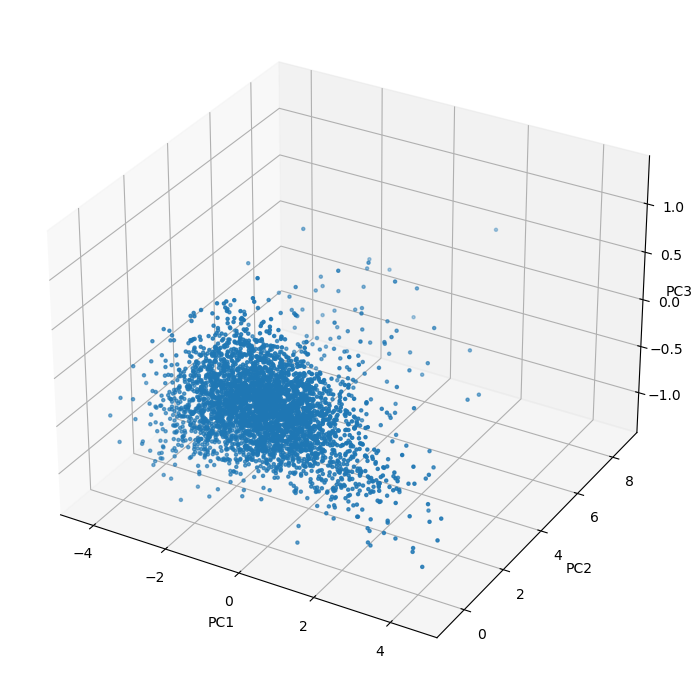

In [7]:
pca = PCA(n_components=3)
pca_normal = pca.fit_transform(tb_data.loc[tb_data['Type'] == 'Normal', list_independent_variables])
list_pca_normal_cols = [f'PC{i + 1}' for i in range(pca_normal.shape[1])]
pca_normal = pd.DataFrame(data=pca_normal, columns=list_pca_normal_cols)

pc1 = pca_normal['PC1']
pc2 = pca_normal['PC2']
pc3 = pca_normal['PC3']

fig, ax = plt.subplots(subplot_kw={'projection': '3d'}, figsize=(7, 7))

ax.scatter(pc1, pc2, pc3, marker='.')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

ax.zaxis.labelpad = -5  # 원하는 간격 크기를 설정하세요

# azimuth_angle = 45
# elevation_angle = 45
# ax.view_init(elev=elevation_angle, azim=azimuth_angle)

plt.tight_layout()

plt.show()

In [8]:
warnings.filterwarnings('ignore')

weighted_data = tb_data.copy()
weighted_data['Max'] = weighted_data['Max'] * 6

type_normal = weighted_data[weighted_data['Type'] == 'Normal']
type_not_normal = weighted_data[weighted_data['Type'] != 'Normal']

normal_mean = type_normal[list_independent_variables].mean()
normal_cov = type_normal[list_independent_variables].cov()

def mahalanobis_distance(x):
    return distance.mahalanobis(x, normal_mean, normal_cov)

type_normal['Mahalanobis Distance'] = type_normal[list_independent_variables].apply(mahalanobis_distance, axis = 1)
type_not_normal['Mahalanobis Distance'] = type_not_normal[list_independent_variables].apply(mahalanobis_distance, axis = 1)

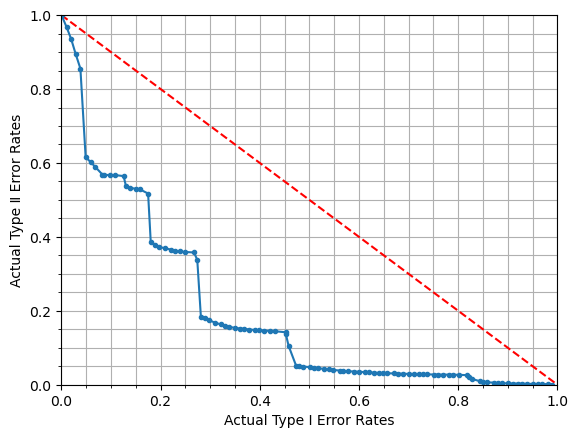

In [9]:
def calculate_error_rates(type_normal, type_not_normal, confidence_level, bootstrap_iterations=100):
    list_bootstrap_statistics = []

    for _ in range(bootstrap_iterations):
        bootstrap_sample = np.random.choice(type_normal['Mahalanobis Distance'], size=len(type_normal), replace=True)
        list_bootstrap_statistics.append(np.percentile(bootstrap_sample, confidence_level))

    control_limit = np.mean(list_bootstrap_statistics)

    type_normal['Confusion Matrix'] = np.where(type_normal['Mahalanobis Distance'] >= control_limit, 'FalseAlarm', 'TrueNegative')
    type_not_normal['Confusion Matrix'] = np.where(type_not_normal['Mahalanobis Distance'] >= control_limit, 'TrueAlarm', 'MissDetection')

    tb_data = pd.concat([type_normal, type_not_normal], axis=0)

    Type1ErrorRates = round(len(tb_data[tb_data['Confusion Matrix'] == 'FalseAlarm']) / len(type_normal), 4)
    Type2ErrorRates = round(len(tb_data[tb_data['Confusion Matrix'] == 'MissDetection']) / len(type_not_normal), 4)
    
    type_normal['Confusion Matrix'] = np.nan
    type_not_normal['Confusion Matrix'] = np.nan

    return [(100-confidence_level)/100, Type1ErrorRates, Type2ErrorRates]

list_ER = []
for confidence_level in range(1, 101):
    result = calculate_error_rates(type_normal, type_not_normal, confidence_level)
    list_ER.append(result)
    
x = [item[1] for item in list_ER]
y = [item[2] for item in list_ER]

plt.plot([0, 1], [1, 0], linestyle='--', color='red')#, label='y = -x')
plt.plot(x, y, marker='.', linestyle='-')

plt.xlabel("Actual Type Ⅰ Error Rates")
plt.ylabel("Actual Type Ⅱ Error Rates")

plt.minorticks_on()
plt.grid(axis='both', which='both')

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.show()

##### 제2종오류 비율을 낮추기 위해 알파를 크게 설정하는 것은 후에 분류 모델에 의존하는 것과 같다고 생각한다. 어떻게 해결하지
##### Weighted mahalanobis distance (GPT가 Bhattacharyya 거리, Minkowski 거리, Geodesic 거리와 KL Divergence도 추천해주더라)
##### 알파를 0.5로 설정해야지. 그런데 특정변수에 가중치를 6배 줄 바엔 단일변수로 이상감지하는 게 자원과 시간을 절약할 수 있지 않았을까
##### Bootstrap T² 적용하고 싶으니 안고 가야지

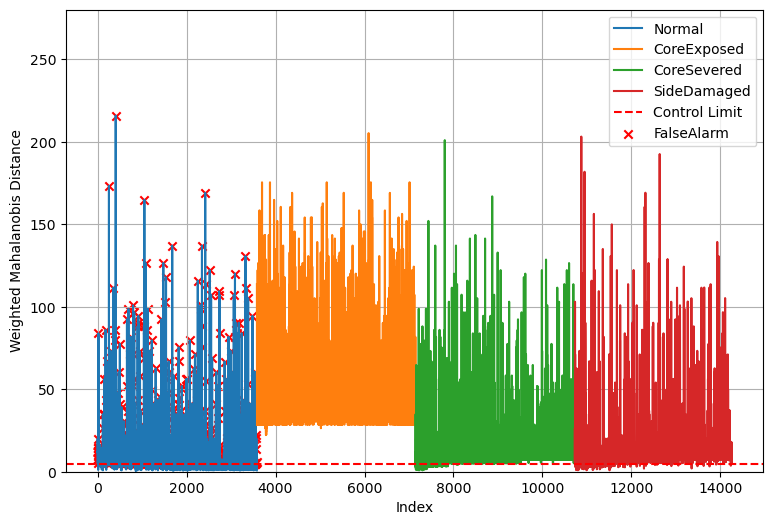

In [10]:
list_bootstrap_statistics = []

bootstrap_iterations = 100
confidence_level = 50

for _ in range(bootstrap_iterations):
    bootstrap_sample = np.random.choice(type_normal['Mahalanobis Distance'], size=len(type_normal), replace=True)
    list_bootstrap_statistics.append(np.percentile(bootstrap_sample, confidence_level))

control_limit = np.mean(list_bootstrap_statistics)

type_normal['Confusion Matrix'] = np.where(type_normal['Mahalanobis Distance'] >= control_limit, 'FalseAlarm', 'TrueNegative')
type_not_normal['Confusion Matrix'] = np.where(type_not_normal['Mahalanobis Distance'] >= control_limit, 'TrueAlarm', 'MissDetection')

tb_data = pd.concat([type_normal, type_not_normal], axis = 0)

mahalanobis_distance = tb_data['Mahalanobis Distance']

false_alarm_indices = tb_data[tb_data['Confusion Matrix'] == 'FalseAlarm'].index

plt.figure(figsize=(9, 6))

for t in tb_data['Type'].unique():
    type_indices = tb_data[tb_data['Type'] == t].index
    plt.plot(type_indices, mahalanobis_distance[type_indices], label=f'{t}') # 각 'Type'에 대한 Mahalanobis 거리 플롯
    
plt.axhline(y=control_limit, color='red', linestyle='--', label='Control Limit') # Control Limit 그리기

plt.scatter(false_alarm_indices, mahalanobis_distance[false_alarm_indices], c='red', marker='x', label='FalseAlarm') # 'Confusion Matrix' 값이 'Type1Error'인 데이터 포인트 표시

plt.xlabel('Index')
plt.ylabel('Weighted Mahalanobis Distance')
# plt.title('Mahalanobis Distance Monitoring Chart with Type Ⅰ Error')
plt.legend()

plt.grid()

# plt.xticks([])

plt.ylim(0, 280)

plt.show()

In [11]:
tb_data[(tb_data['Type'] == 'Normal') & (tb_data['Confusion Matrix'] == 'FalseAlarm')] # False Alarm 갯수 알아보기

,Unnamed: 0,Tension,Variance,Kurtosis,Max,Type,Confusion Matrix,Mahalanobis Distance
0,2023-05-31 23:35:19,-0.216452,0.235485,0.005047,-6.910902,Normal,FalseAlarm,11.971122
1,2023-05-31 23:35:20,-0.204667,0.059753,-0.858885,0.822804,Normal,FalseAlarm,19.969164
2,2023-05-31 23:35:21,-0.216452,0.163329,-0.392346,-7.426482,Normal,FalseAlarm,14.122634
3,2023-05-31 23:35:22,-0.240023,0.503912,-0.731790,-2.786259,Normal,FalseAlarm,5.196151
4,2023-05-31 23:35:23,-0.240023,1.351871,-1.517878,-6.910902,Normal,FalseAlarm,12.307428
...,...,...,...,...,...,...,...,...
3559,2023-06-01 00:34:38,-0.322522,-2.352653,1.998218,-4.848580,Normal,FalseAlarm,5.053822
3561,2023-06-01 00:34:40,-0.263594,2.056849,-2.243221,-4.848580,Normal,FalseAlarm,5.300689
3563,2023-06-01 00:34:42,-0.310736,-0.973401,0.109594,-0.723937,Normal,FalseAlarm,13.607227
3570,2023-06-01 00:34:49,-0.287165,-1.463280,1.318356,0.822804,Normal,FalseAlarm,20.143802


In [12]:
OOC = tb_data[(tb_data['Confusion Matrix'] == 'FalseAlarm') | (tb_data['Confusion Matrix'] == 'TrueAlarm')].copy()
OOC # Out-of-control

,Unnamed: 0,Tension,Variance,Kurtosis,Max,Type,Confusion Matrix,Mahalanobis Distance
0,2023-05-31 23:35:19,-0.216452,0.235485,0.005047,-6.910902,Normal,FalseAlarm,11.971122
1,2023-05-31 23:35:20,-0.204667,0.059753,-0.858885,0.822804,Normal,FalseAlarm,19.969164
2,2023-05-31 23:35:21,-0.216452,0.163329,-0.392346,-7.426482,Normal,FalseAlarm,14.122634
3,2023-05-31 23:35:22,-0.240023,0.503912,-0.731790,-2.786259,Normal,FalseAlarm,5.196151
4,2023-05-31 23:35:23,-0.240023,1.351871,-1.517878,-6.910902,Normal,FalseAlarm,12.307428
...,...,...,...,...,...,...,...,...
14250,2023-05-31 21:53:55,-0.298951,-1.108551,1.508766,-2.528469,SideDamaged,TrueAlarm,6.563707
14251,2023-05-31 21:53:56,-0.240023,-0.717530,0.607366,-2.786259,SideDamaged,TrueAlarm,5.189895
14252,2023-05-31 21:53:57,0.007473,0.135900,-0.148179,-2.786259,SideDamaged,TrueAlarm,5.077527
14253,2023-05-31 21:53:58,-0.263594,-1.534583,1.726651,-2.786259,SideDamaged,TrueAlarm,5.825810


In [13]:
OOC = tb_data[(tb_data['Confusion Matrix'] == 'FalseAlarm') | (tb_data['Confusion Matrix'] == 'TrueAlarm')].copy() # Out-of-control

x2 = OOC[list_independent_variables]
y2 = OOC['Confusion Matrix']

mutual_info = mutual_info_classif(x2, y2, discrete_features='auto', random_state=42)

importance_scores = pd.Series(mutual_info, index=x2.columns)
importance_scores = importance_scores.sort_values(ascending=False)
print('변수 중요도')
print(importance_scores)

변수 중요도
Max         0.293858
Tension     0.075689
Variance    0.012740
Kurtosis    0.006663
dtype: float64


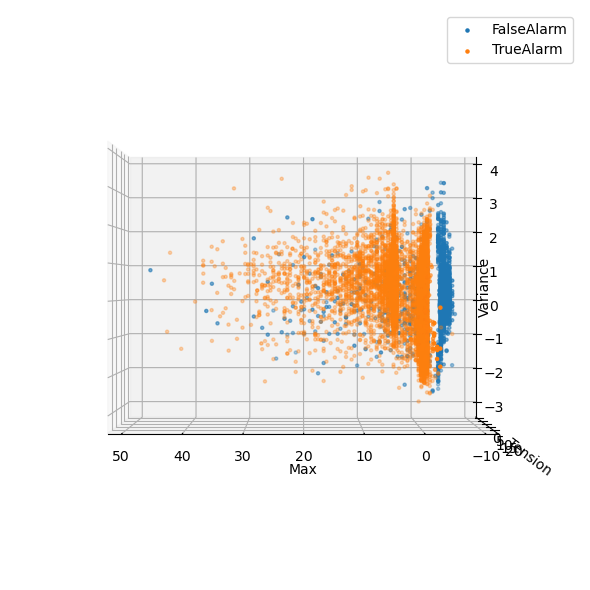

In [14]:
fig = plt.figure(figsize=(6, 6))

ax = fig.add_subplot(111, projection='3d')
tension = OOC['Tension']
variance = OOC['Variance']
max = OOC['Max']
confusion_matrix = OOC['Confusion Matrix']

for t in OOC['Confusion Matrix'].unique().tolist():
    mask = confusion_matrix == t
    ax.scatter(max[mask], tension[mask], variance[mask], label = t, marker = '.')

ax.set_xlabel('Max')
ax.set_ylabel('Tension')
ax.set_zlabel('Variance')

azimuth_angle = 90
elevation_angle = -0
ax.view_init(elev=elevation_angle, azim=azimuth_angle)
ax.zaxis.labelpad = -15

ax.legend()
# plt.title('Scatter Plot of Tension, Mean, and Skewness')
plt.tight_layout()
plt.show()

In [15]:
from sklearn.metrics import confusion_matrix

x_tr, x_ts, y_tr, y_ts = train_test_split(x2, y2, test_size = 0.5, random_state = 42, stratify = y2)
print("Train Data:", x_tr.shape, "Test Data:", x_ts.shape)

clf = RandomForestClassifier(n_estimators = 100, criterion = 'gini', max_depth = 3, bootstrap = True, class_weight = 'balanced', random_state = 42)
clf.fit(x_tr, y_tr)

y_tr_pred = clf.predict(x_tr)

print(f"훈련 데이터 정확도: {accuracy_score(y_tr, y_tr_pred)}")

y_ts_pred = clf.predict(x_ts)

print(f"테스트 데이터 정확도: {accuracy_score(y_ts, y_ts_pred)}")

print("Confusion Matrix:")
print(confusion_matrix(y_ts, y_ts_pred))

print("Classification Report:")
print(classification_report(y_ts, y_ts_pred))

Train Data: (5980, 4) Test Data: (5980, 4)
훈련 데이터 정확도: 0.9657190635451505
테스트 데이터 정확도: 0.9652173913043478
Confusion Matrix:
[[ 696  201]
 [   7 5076]]
Classification Report:
              precision    recall  f1-score   support

  FalseAlarm       0.99      0.78      0.87       897
   TrueAlarm       0.96      1.00      0.98      5083

    accuracy                           0.97      5980
   macro avg       0.98      0.89      0.92      5980
weighted avg       0.97      0.97      0.96      5980



In [16]:
print(len(y_ts[y_ts == 'FalseAlarm']))
print(len(y_ts_pred[y_ts_pred == 'FalseAlarm']))
print(len(y_ts[y_ts != 'FalseAlarm']))
print(len(y_ts_pred[y_ts_pred != 'FalseAlarm']))

897
703
5083
5277


In [17]:
# FAC 적용 후 변화한 Erorr Rates 알아보기
Normal_dnmntr = len(tb_data[tb_data['Type'] == 'Normal']) - len(y_tr[y_tr == 'FalseAlarm'])
n_FalseAlarm = len(y_ts[y_ts == 'FalseAlarm']) - sum((y_ts == 'FalseAlarm') & (y_ts_pred == 'FalseAlarm'))

FAC_Type1ErrorRate = n_FalseAlarm/Normal_dnmntr

Others_dnmntr = len(tb_data[tb_data['Type'] != 'Normal']) + sum((y_ts == 'TrueAlarm') & (y_ts_pred == 'FalseAlarm'))
n_MissDetection = len(tb_data[tb_data['Confusion Matrix'] == 'MissDetection']) + sum((y_ts == 'TrueAlarm') & (y_ts_pred == 'FalseAlarm'))

FAC_Type2ErrorRate = n_MissDetection / Others_dnmntr

print(f'FAC 적용 후 Actual Type Ⅰ Error Rates: {FAC_Type1ErrorRate}')
print(f'FAC 적용 후 Actual Type Ⅱ Error Rates: {FAC_Type2ErrorRate}')

FAC 적용 후 Actual Type Ⅰ Error Rates: 0.0748882265275708
FAC 적용 후 Actual Type Ⅱ Error Rates: 0.04821645913303998


##### 알파를 0.5로 설정했을 때, Bootstrap T²에 대한 제1종, 제2종 오류 비율은 각각 약 0.5, 0.05이었다.
##### False Alarm Classification을 거친 뒤 변화한 오류 비율은 각각 약 0.07, 0.05이다.
##### 이제 유의수준에 따라 오류 비율은 어떻게 변화하는지 알아보겠다.

In [30]:
tb_data = pd.concat(data_frames.values(), ignore_index=True)
tb_data = tb_data.rename(columns={'벨트처짐': 'Tension'})

list_independent_variables = ['Tension', 'Variance', 'Kurtosis', 'Max']

data_standardized = StandardScaler().fit_transform(tb_data[list_independent_variables])
tb_data[list_independent_variables] = pd.DataFrame(data_standardized, columns=list_independent_variables)

weighted_data = tb_data.copy()
weighted_data['Max'] = weighted_data['Max'] * 6

type_normal = weighted_data[weighted_data['Type'] == 'Normal']
type_not_normal = weighted_data[weighted_data['Type'] != 'Normal']

normal_mean = type_normal[list_independent_variables].mean()
normal_cov = type_normal[list_independent_variables].cov()

def mahalanobis_distance(x):
    return distance.mahalanobis(x, normal_mean, normal_cov)

type_normal['Mahalanobis Distance'] = type_normal[list_independent_variables].apply(mahalanobis_distance, axis = 1)
type_not_normal['Mahalanobis Distance'] = type_not_normal[list_independent_variables].apply(mahalanobis_distance, axis = 1)

def calculate_error_rates_ver_2(type_normal, type_not_normal, confidence_level, bootstrap_iterations=100):
    list_bootstrap_statistics = []

    for _ in range(bootstrap_iterations):
        bootstrap_sample = np.random.choice(type_normal['Mahalanobis Distance'], size=len(type_normal), replace=True)
        list_bootstrap_statistics.append(np.percentile(bootstrap_sample, confidence_level))

    control_limit = np.mean(list_bootstrap_statistics)

    type_normal['Confusion Matrix'] = np.where(type_normal['Mahalanobis Distance'] >= control_limit, 'FalseAlarm', 'TrueNegative')
    type_not_normal['Confusion Matrix'] = np.where(type_not_normal['Mahalanobis Distance'] >= control_limit, 'TrueAlarm', 'MissDetection')

    tb_data = pd.concat([type_normal, type_not_normal], axis=0)

    Type1ErrorRates = round(len(tb_data[tb_data['Confusion Matrix'] == 'FalseAlarm']) / len(type_normal), 4)
    Type2ErrorRates = round(len(tb_data[tb_data['Confusion Matrix'] == 'MissDetection']) / len(type_not_normal), 4)
    
    OOC = tb_data[(tb_data['Confusion Matrix'] == 'FalseAlarm') | (tb_data['Confusion Matrix'] == 'TrueAlarm')].copy()
    
    x2 = OOC[list_independent_variables]
    y2 = OOC['Confusion Matrix']
    
    x_tr, x_ts, y_tr, y_ts = train_test_split(x2, y2, test_size = 0.5, random_state = 42, stratify = y2)
    
    RandomForestC = RandomForestClassifier(n_estimators = 100, criterion = 'gini', max_depth = 3, bootstrap = True, class_weight = 'balanced', random_state = 42)
    RandomForestC.fit(x_tr, y_tr)

    y_ts_pred = RandomForestC.predict(x_ts)
    
    Normal_dnmntr = len(tb_data[tb_data['Type'] == 'Normal']) - len(y_tr[y_tr == 'FalseAlarm'])
    n_FalseAlarm = len(y_ts[y_ts == 'FalseAlarm']) - sum((y_ts == 'FalseAlarm') & (y_ts_pred == 'FalseAlarm'))

    FAC_Type1ErrorRate = n_FalseAlarm/Normal_dnmntr

    Others_dnmntr = len(tb_data[tb_data['Type'] != 'Normal']) + sum((y_ts == 'TrueAlarm') & (y_ts_pred == 'FalseAlarm'))
    n_MissDetection = len(tb_data[tb_data['Confusion Matrix'] == 'MissDetection']) + sum((y_ts == 'TrueAlarm') & (y_ts_pred == 'FalseAlarm'))

    FAC_Type2ErrorRate = n_MissDetection / Others_dnmntr
    
    type_normal['Confusion Matrix'] = np.nan
    type_not_normal['Confusion Matrix'] = np.nan

    return [(100-confidence_level)/100, Type1ErrorRates, Type2ErrorRates, FAC_Type1ErrorRate, FAC_Type2ErrorRate]

list_ER_ver_2 = []
for confidence_level in range(1, 100):
    result = calculate_error_rates_ver_2(type_normal, type_not_normal, confidence_level)
    list_ER_ver_2.append(result)

x = [item[1] for item in list_ER_ver_2]
y = [item[2] for item in list_ER_ver_2]
x3 = [item[3] for item in list_ER_ver_2]
y3 = [item[4] for item in list_ER_ver_2]

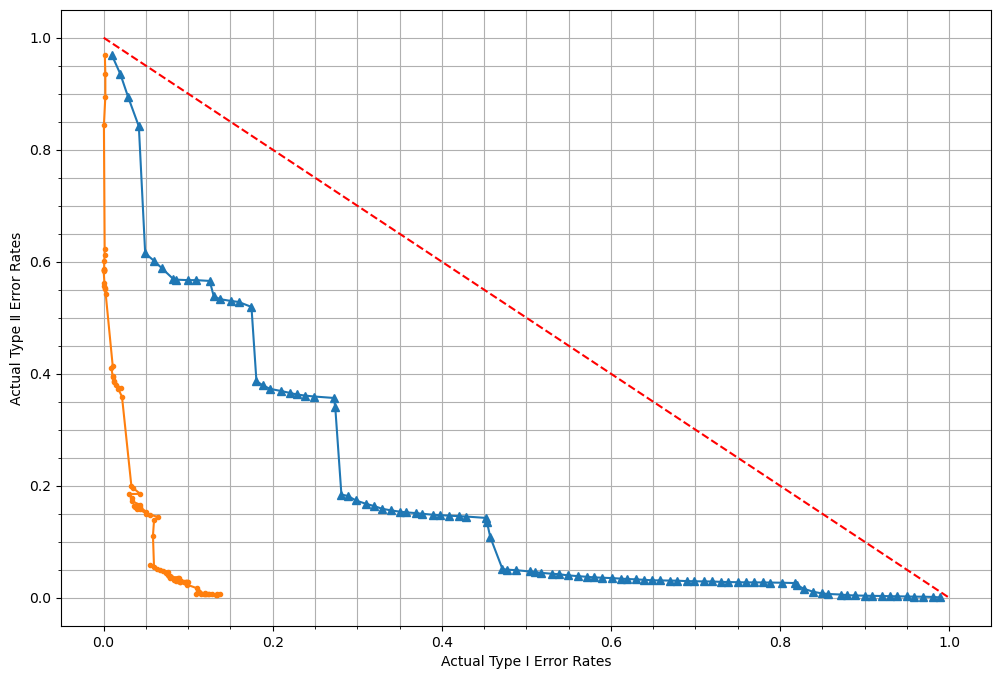

In [35]:
plt.figure(figsize = (12, 8))

plt.plot([0, 1], [1, 0], linestyle='--', color='red')#, label='y = -x')
plt.plot(x, y, marker='^', linestyle='-', label = 'Bootstrap T²')
plt.plot(x3, y3, marker='.', linestyle='-', label = 'with FAC')

plt.xlabel("Actual Type Ⅰ Error Rates")
plt.ylabel("Actual Type Ⅱ Error Rates")

plt.minorticks_on()
plt.grid(axis='both', which='both')

# plt.xlim(0, 1)
# plt.ylim(0, 1)

plt.legend

plt.show()